In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import catboost as ctb

In [2]:
def metric(y_true, y_pred):
    
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_pred) * 100

In [3]:
df = pd.read_csv("data_regression_for_task.csv")

In [4]:
df.head()

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
0,2017,4,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.0,0.0
1,2017,4,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.0,0.0
2,2017,4,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.0,0.0
3,2017,4,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.0,0.0
4,2017,4,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.0,0.0


In [5]:
df.shape

(128355, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128355 entries, 0 to 128354
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   YEAR           128355 non-null  int64  
 1   MONTH          128355 non-null  int64  
 2   CONTRAGENT     128331 non-null  object 
 3   ARTICLE_CODE   128355 non-null  object 
 4   ARTICLE_NAME   128355 non-null  object 
 5   ARTICLE_GROUP  128354 non-null  object 
 6   SALES          128355 non-null  float64
 7   STORE_SALES    128355 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 7.8+ MB


Мало миссингов, просто дропнем их

In [7]:
df.dropna(inplace=True)
df.shape

(128330, 8)

In [8]:
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH']].assign(DAY=1))
df.set_index(['YEAR', 'MONTH'], inplace=True)

In [9]:
summary_stat = df["SALES"].describe()
summary_stat

count    1.283300e+05
mean     6.564316e+03
std      2.892762e+04
min     -6.490000e+03
25%      0.000000e+00
50%      3.300000e+02
75%      3.250000e+03
max      1.616600e+06
Name: SALES, dtype: float64

Отрицательные продажи. Странно. Посмотрим сколько таких

In [10]:
negative_sales = df["SALES"].loc[df["SALES"] < 0]
negative_sales.describe()

count      55.000000
mean     -537.454545
std       993.986024
min     -6490.000000
25%      -505.000000
50%      -170.000000
75%       -85.000000
max       -10.000000
Name: SALES, dtype: float64

Наверное отклонение от плановых продаж, оставим.
Нет. Судя по метрике качества, такого не должно быть

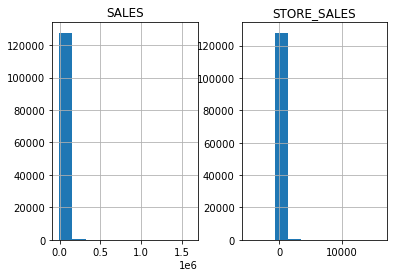

In [11]:
hist = df.hist(bins=10)

In [12]:
df = df.loc[(df["SALES"] >= 0) & (df["STORE_SALES"] >= 0)]
df.shape

(127993, 7)

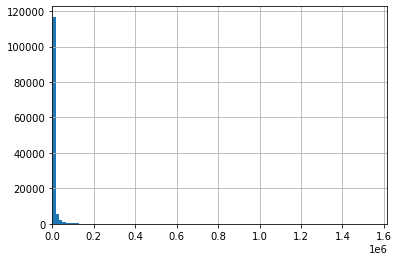

In [13]:
df["SALES"].hist(bins=100)
plt.xlim(df["SALES"].min(), df["SALES"].max())
plt.show()

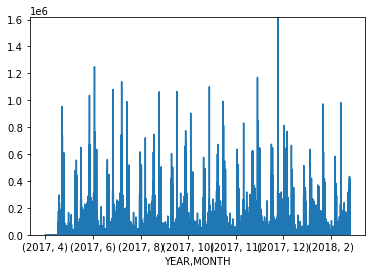

In [14]:
df["SALES"].plot()
plt.ylim(df["SALES"].min(), df["SALES"].max())
plt.show()

Присутствует сезонность. 
Посмотрим на категориальные признаки

In [15]:
for var in ["CONTRAGENT", "ARTICLE_CODE", "ARTICLE_NAME", "ARTICLE_GROUP"]:
    tab = df[var].value_counts()
    tab = tab[tab < 30]
    tot_vals = len(df[var].unique())
    max_val = df[var].value_counts().max()
    
    print(var)
    print(f"Контагентов с малой выборкой: {tab.count()}")
    print(f"Всего контагентов: {tot_vals}")
    print(f"Максимальная выборка: {max_val}\n")    

CONTRAGENT
Контагентов с малой выборкой: 118
Всего контагентов: 333
Максимальная выборка: 9820

ARTICLE_CODE
Контагентов с малой выборкой: 23538
Всего контагентов: 23538
Максимальная выборка: 10

ARTICLE_NAME
Контагентов с малой выборкой: 23603
Всего контагентов: 23603
Максимальная выборка: 19

ARTICLE_GROUP
Контагентов с малой выборкой: 0
Всего контагентов: 7
Максимальная выборка: 78885



Много значений с низкой частотой и большое их количество. Надо в тренировочной выборке отбирать кейсы, присутствующие в тестовой. Но лучше использовать mean shift target encoding, тогда можно тренироваться и на миссингах, и предсказывать невиданные до этого значения признаков. Воспользуемся CatBoost, который сделает это за нас

In [16]:
df.reset_index(inplace=True)
df.set_index(["DATE"], inplace=True)
df.head()

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
DATE,,,,,,,,
2017-04-01,2017,4,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.0,0.0
2017-04-01,2017,4,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.0,0.0
2017-04-01,2017,4,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.0,0.0
2017-04-01,2017,4,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.0,0.0
2017-04-01,2017,4,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.0,0.0


In [17]:
X_list = ["YEAR", "MONTH", "CONTRAGENT", "ARTICLE_CODE", "ARTICLE_NAME", "ARTICLE_GROUP", "STORE_SALES"]
cat_vars = ["CONTRAGENT", "ARTICLE_CODE", "ARTICLE_NAME", "ARTICLE_GROUP"]

In [18]:
X_train = df.loc[df.index < '2018-02-01', X_list]
y_train = df.loc[df.index < '2018-02-01', "SALES"]

X_test = df.loc[df.index == '2018-02-01', X_list]
y_test = df.loc[df.index == '2018-02-01', "SALES"]

In [19]:
X_train.shape

(114936, 7)

In [20]:
y_train.shape

(114936,)

In [21]:
model = ctb.CatBoostRegressor(
    cat_features = cat_vars,
    loss_function = "RMSE",
    random_state = 42
)

In [1]:
grid = {
    'iterations':[1000, 1100, 1200],
    'learning_rate': [0.06, 0.09, 1],
    'depth': [2,3,4]
}

grid_search_result = model.grid_search(grid,
                                       X=X_train,
                                       y=y_train,
                                       plot=True)

In [23]:
model = ctb.CatBoostRegressor(
    cat_features = cat_vars,
    loss_function = "RMSE",
    random_state = 42,
    iterations = 1200,
    learning_rate = 0.9,
    depth = 4
)

In [2]:
model.fit(X_train, y_train)

In [25]:
y_pred = model.predict(X_test)

In [26]:
metric(y_test, y_pred)

80.88211557134366

In [27]:
model.score(X_test,y_test)

0.5710808918463519

Возможно, стоило брать SARIMA. Преобразовать таргет. Ну, как получилось